In [2]:
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
def pad_image(image_path,target_size):
  img = Image.open(image_path).convert('RGB')
  resized_img = T.Resize(target_size,max_size=512)(img)
  padding = get_padding_sizes(resized_img,target_size)
  result = T.Pad(padding,0,"constant")(resized_img)
  return result,(image_path,result.size)

def get_padding_sizes(image, target_size):
  width, height = image.size
  hor_pad_size = target_size - width      # yatay olarak padding alanı boyutu
  ver_pad_size = target_size - height     # düşey olarak padding alanı boyutu
  padding_left = hor_pad_size//2
  padding_right = hor_pad_size - padding_left
  padding_top = ver_pad_size//2
  padding_bottom = ver_pad_size - padding_top
  padding = (padding_left,padding_top,padding_right,padding_bottom)
  return padding

def display_pil_image(image_path,new_size=224):
  result = pad_image(image_path,new_size)
  display(result[0])
  return result[1]

def sort_image_list(lst):
  new_lst = []
  extensions = {}
  for i in range(0,len(lst)):
    id = Path(lst[i]).stem
    extensions[id] = lst[i][-4:]
    new_lst.append(int(id))

  new_lst = sorted(new_lst)

  for i in range(0,len(lst)):
    id = str(new_lst[i])
    new_lst[i]= id + extensions[id]
  return new_lst

def display_images_labels(imgs_lst,labels_file):
  new_img_lst = sort_image_list(imgs_lst)
  return pd.DataFrame({
      "image" : [img for img in new_img_lst],
      "id" : [labels_file.iloc[i,0] for i in range(0,len(labels_file))],
      "Hata" : [labels_file.iloc[i,1] for i in range(0,len(labels_file))],
      "Type" : [labels_file.iloc[i,2] for i in range(0,len(labels_file))]
      })

def create_images_list(dir,sort=False,fullPath=False):
  lst = os.listdir(dir)

  if sort:
    lst = sort_image_list(lst)

  if fullPath:
    for i,img in enumerate(lst):
      path = os.path.join(dir,img)
      lst[i] = path

  return lst

def merge_image_directories(dir1,dir2,sort=False,fullPath=False):
  list1 = create_images_list(dir1,sort,fullPath)
  list2 = create_images_list(dir2,sort,fullPath)
  total = list1 + list2
  return total

## Image list must be sorted before call this function.
## Call sort_image_list function
def create_img_label_dict(imgs_lst,labels_lst,column_num:int):
  dict = {}
  for i,img in enumerate(imgs_lst):
    dict[img] = labels_lst.iloc[i,column_num]
  return dict

In [16]:
furkan_images_dir = "/content/drive/MyDrive/Ara_proje_dataset/Furkan_Pan/images"
gamze_images_dir = "/content/drive/MyDrive/Ara_proje_dataset/Gamze_Pan/images"
furkan_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Furkan_Pan/Furkan_Excel.xlsx"
gamze_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Gamze_Pan/Furkan_Excel.xlsx"
total_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Total_Excel.xlsx"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = T.Compose([T.ToTensor(),T.Normalize([0.5], [0.2])])
classes = {0 : "Hatasiz" , 1 : "Hatali"}
new_size = 350      ## Must be less than max_size=512
#transform2 = T.Compose([T.Resize(new_size,max_size=512),T.CenterCrop(new_size)])

In [8]:
f_labels_file = pd.read_excel(furkan_excel_path,header=None,keep_default_na=False)
f_images_paths = create_images_list(furkan_images_dir,sort=True,fullPath=True)
f_img_lbl_dict = create_img_label_dict(f_images_paths,f_labels_file,column_num=1)
pd.Series({
    "labels file length =" : len(f_labels_file),
    "images list length =" : len(f_images_paths),
    "dictionary  length =" : len(f_img_lbl_dict)
}).to_frame().style.hide(axis='columns')

labels file length =,750
images list length =,750
dictionary length =,750


In [85]:
display_images_labels(f_images_paths,f_labels_file)

,image,id,Hata,Type
0,1.jpg,1,0,
1,2.jpg,2,1,3
2,3.jpg,3,1,4
3,4.jpg,4,0,
4,5.jpg,5,1,4
...,...,...,...,...
745,2245.jpg,2245,1,3
746,2246.jpg,2246,0,0
747,2247.jpg,2247,1,5
748,2248.jpg,2248,1,2


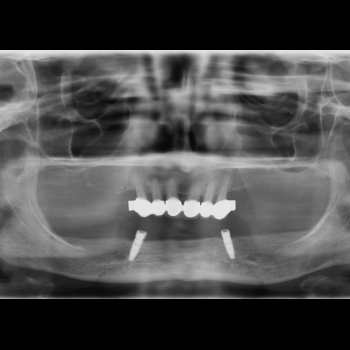

In [21]:
s = random.choice(f_images_paths)
img, info = pad_image(s,new_size)
print(f"İmage info: {info[0]} , image size: {info[1]}")
#img = Image.open(s)
#trans_img = transform2(img)
#trans_img

In [5]:
class ImageDataset(Dataset):
  def __init__(self, annotations, img_paths, transform=None):
    self.img_paths = img_paths
    self.labels = annotations
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    result = pad_image(self.img_paths[idx],new_size)
    label = self.labels[idx]
    if self.transform:
        image = self.transform(result[0])
    return image, label

In [6]:
x = f_images_paths
y = []
for i in range(0,len(f_labels_file)):
  y.append(f_labels_file.iloc[i,1])
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=75,stratify=y)
print(f"train data length: {len(x_train)} , test data length: {len(x_test)}")

train data length: 600 , test data length: 150


In [7]:
train_dataset = ImageDataset(y_train,x_train,transform)
test_dataset = ImageDataset(y_test,x_test,transform)
print(f"train dataset length: {len(train_dataset)} , test dataset length: {len(test_dataset)}")

train dataset length: 600 , test dataset length: 150


In [8]:
batch_size = 20
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=2,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=2,shuffle=True)
pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in test DataLoader:': len(test_dataloader)}
).to_frame().style.hide(axis='columns')

Number of batches in train DataLoader:,30
Number of batches in test DataLoader:,8


In [9]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 179MB/s]


In [10]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, len(classes))
        )

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

model = DinoVisionTransformerClassifier()
model = model.to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=3e-5)

In [ ]:
num_epoch = 10
model.train()
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(train_dataloader)
    for idx, (features, labels) in enumerate(loop):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_fn(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size

        loss.backward()
        optimizer.step()

        tqdm(train_dataloader).set_description(f"Epoch [{epoch}/{num_epoch}]")
        tqdm(train_dataloader).set_postfix(loss=loss.item(), acc=accuracy)

In [13]:
correct = 0
total = 0
model.eval()
test_predicted = []
test_labels = []

with torch.no_grad():
    for features, labels in test_dataloader:
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to(device) == labels).sum().item()

        test_labels += (labels.cpu().numpy().tolist())
        test_predicted += (predicted.cpu().numpy().tolist())

print(f'Accuracy of the network on the {len(test_dataloader)*6} test images: {100 * correct // total} %')

Accuracy of the network on the 48 test images: 52 %


In [14]:
print(classification_report(test_labels, test_predicted, target_names=list(classes.values())))

              precision    recall  f1-score   support

     Hatasiz       0.83      0.07      0.12        76
      Hatali       0.51      0.99      0.67        74

    accuracy                           0.52       150
   macro avg       0.67      0.53      0.40       150
weighted avg       0.67      0.52      0.39       150

